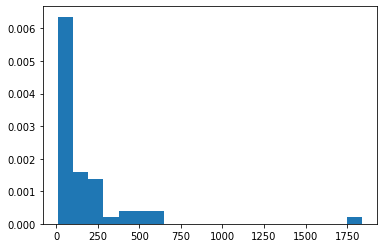

In [7]:
# Import modules
from evaluation_tools.nwis_client.iv import IVDataService
from evaluation_tools.events.event_detection import decomposition as ev
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Retrieve streamflow data
observations = IVDataService.get(
    sites='02146470',
    startDT='2019-10-01',
    endDT='2020-09-30'
    )

# Isolate time series of streamflow measurements
observations = observations[['value_date', 'value']]
observations = observations.drop_duplicates(subset=['value_date'])
observations = observations.set_index('value_date')
observations = observations.resample('H').first().ffill()

# Smooth noisy data
observations['smooth'] = observations['value'].ewm(halflife='6H', times=observations.index).mean()

# Model the trend using a 7-day rolling minimum
observations['trend'] = ev.rolling_minimum(observations['smooth'], '7D')

# Detrend the data
observations['detrended'] = observations['smooth'].sub(observations['trend'])

# Ignore detrended values below measurement precision
observations.loc[(observations['detrended'] < 0.01), 'detrended'] = 0.0

# Detrended signal should have a zero median
residual = observations['detrended'].median() * 2.0
observations.loc[(observations['detrended'] < residual), 'detrended'] = 0.0

# Mask in-event measurements
observations['event'] = (observations['detrended'] > 0.0)

# Aggregate continguous event measurements into discrete events
events = ev.event_boundaries(observations['event'])

# Tweak events
events['start'] = events['start'].apply(ev.find_local_minimum, radius='7H', timeseries=observations['value'])

# Compute event durations
events['duration'] = (events['end'].sub(events['start'])).div(pd.Timedelta('1H'))

# Compute peak flows
events['peak'] = events.apply(
    lambda e: observations['value'].loc[e.start:e.end].max(),
    axis=1
    )

# Filter out small events less than 6 hours or with peaks less than 10 CFS
events = events[events['duration'] >= 6.0]
events = events[events['peak'] >= 10.0]

# Plot histogram of peaks and durations
# observations[['value']].plot(logy=True)
plt.hist(events['peak'], bins=20, density=True)
# plt.plot(events['start'], events['duration'], 'o')
# plt.ylim(0,50)
plt.show()